

#Important imports

In [1]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import accuracy_score
from datetime import datetime
import nltk  
from nltk.util import ngrams
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import MWETokenizer
wordnet_lemmatizer = WordNetLemmatizer()
pd.reset_option('display.float_format')
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
cd /Users/chiragrakholiya/Downloads/Project2/

/Users/chiragrakholiya/Downloads/Project2


<H1>Change the directory to the exact path where the file is </H1> 
cd Downloads/Project2

In [3]:
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

data = pd.read_csv('hn2018_2019.csv', parse_dates=['Created At'], date_parser=dateparse)
data.head()

,Unnamed: 0,Object ID,Title,Post Type,Author,Created At,URL,Points,Number of Comments
0,2294635,16043786,Top Hacker News Books in 2017,story,0x54MUR41,2018-01-01 00:06:16,https://hackernewsbooks.com/year/2017,1,0.0
1,2294636,16043817,Beijing enjoys best winter air quality in five...,story,gpetukhov,2018-01-01 00:15:13,http://www.scmp.com/news/china/policies-politi...,2,0.0
2,2294637,16043825,Ask HN: Any domain name registrars that don't ...,ask_hn,glockenspielen,2018-01-01 00:16:54,NaN,1,2.0
3,2294638,16043845,Controversial Therapy Has Led to Death Threats...,story,cpncrunch,2018-01-01 00:23:05,https://www.buzzfeed.com/tomchivers/inside-the...,2,0.0
4,2294639,16043851,Ruby 3x3 – Ruby 3 Will Be 3 Times Faster – Wha...,story,geraldbauer,2018-01-01 00:25:05,https://planetruby.github.io/advent2017/ruby3x3,2,0.0


<H1>Dividing the Data into Training or testing based on the dates</H1> 
<H4>All the Articles before 1st January 2019 Goes to training dataset and rest in testing dataset</H4>

In [4]:
type(data['Created At'][0])
split_date=pd.datetime(2019,1,1)
df_train = data.loc[data['Created At'] < split_date]
df_test = data.loc[data['Created At'] >= split_date]

<H2> Data Visulaization</H2>

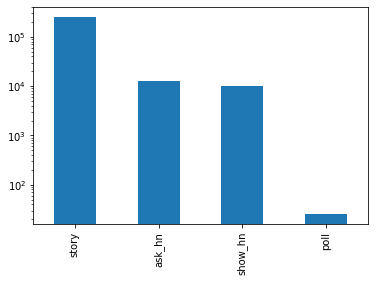

In [5]:
df=df_train['Post Type'].value_counts()
df.plot.bar()
plt.yscale("log")   #Because Poll value was small we have took log of the values
plt.show()

In [6]:
def preprocess(sentence):
    sentence=sentence.encode("ascii", errors="ignore").decode()
    sentence = sentence.lower()
    #tokenizer = RegexpTokenizer(r'\w+')
    tk = MWETokenizer([('ask', 'hn:'), ('show', 'hn:')])
    tokens = tk.tokenize(sentence.split())
    #tokens=[i.strip('+-:?*_,()""~$#%\'\|\!=+{}') for i in tokens]
    lemma_words=[wordnet_lemmatizer.lemmatize(w) for w in tokens]
    return lemma_words

In [7]:
vectorizer = CountVectorizer(tokenizer=preprocess)
X = vectorizer.fit_transform(df_train['Title'])
Vocabulary=vectorizer.vocabulary_

In [8]:
Vocabulary

{'top': 124492,
 'hacker': 61684,
 'news': 87367,
 'book': 27484,
 'in': 67335,
 '2017': 11653,
 'beijing': 25082,
 'enjoys': 49539,
 'best': 25402,
 'winter': 134456,
 'air': 18023,
 'quality': 101456,
 'five': 54490,
 'year': 136286,
 'ask_hn:': 21835,
 'any': 20316,
 'domain': 45636,
 'name': 86001,
 'registrar': 104433,
 'that': 122773,
 "don't": 45713,
 'require': 105408,
 'javascript?': 70669,
 'controversial': 37255,
 'therapy': 122946,
 'ha': 61592,
 'led': 75116,
 'to': 124097,
 'death': 41611,
 'threats,': 123289,
 'harassment': 62312,
 'and': 19474,
 'pseudoscience': 100325,
 'ruby': 107881,
 '3x3': 13031,
 '3': 12410,
 'will': 134219,
 'be': 24724,
 'time': 123669,
 'faster': 53022,
 "what's": 133668,
 'news?': 87388,
 'breaking': 28370,
 'the': 122793,
 'glass': 59172,
 'level': 75506,
 'cap': 30594,
 'hundred': 65615,
 'of': 90142,
 'pterosaur': 100479,
 'egg': 48106,
 'found': 55925,
 'record-breaking': 103810,
 'fossil': 55898,
 'haul': 62693,
 'shop': 112477,
 'without

<H3>Creating tokens for the title</H3>

In [9]:
df_train=df_train.loc[:,['Title','Post Type']]
df_train['tokenized_words'] = df_train['Title'].map(lambda s:preprocess(s))

In [10]:
df_train.head(5)

,Title,Post Type,tokenized_words
0,Top Hacker News Books in 2017,story,"[top, hacker, news, book, in, 2017]"
1,Beijing enjoys best winter air quality in five...,story,"[beijing, enjoys, best, winter, air, quality, ..."
2,Ask HN: Any domain name registrars that don't ...,ask_hn,"[ask_hn:, any, domain, name, registrar, that, ..."
3,Controversial Therapy Has Led to Death Threats...,story,"[controversial, therapy, ha, led, to, death, t..."
4,Ruby 3x3 – Ruby 3 Will Be 3 Times Faster – Wha...,story,"[ruby, 3x3, ruby, 3, will, be, 3, time, faster..."


<H3> Priors Probabilities </H3>

In [11]:
Unique_posts=df_train['Post Type'].unique().tolist()

In [12]:
Prior_probs={}
for i in range(len(Unique_posts)):
    prob = (len(df_train.loc[df_train['Post Type']== '{}'.format(Unique_posts[i])])/len(df_train))*100
    print("Probabilities of category {} is {}".format(Unique_posts[i],prob))
    Prior_probs[Unique_posts[i]] = prob

Probabilities of category story is 91.7831909047913
Probabilities of category ask_hn is 4.516194251591264
Probabilities of category show_hn is 3.6915889537549504
Probabilities of category poll is 0.009025889862481542


In [13]:
Prior_probs

{'story': 91.7831909047913,
 'ask_hn': 4.516194251591264,
 'show_hn': 3.6915889537549504,
 'poll': 0.009025889862481542}

In [14]:
rows = list()
for row in df_train[['Post Type', 'tokenized_words']].iterrows():
    r = row[1]
    for word in r.tokenized_words:
        rows.append((r['Post Type'], word))


In [15]:
dictionary = pd.DataFrame(rows, columns=['Post Type', 'word'])
#dictionary = dictionary[dictionary['word'].isin(Vocabulary)]
dictionary.head(13)

,Post Type,word
0,story,top
1,story,hacker
2,story,news
3,story,book
4,story,in
5,story,2017
6,story,beijing
7,story,enjoys
8,story,best
9,story,winter


<H3> Total Words in Each Category</H3>

In [17]:
dictionary = dictionary[dictionary.word.str.len() > 1]
dictionary.sort_values(by=['word'])

,Post Type,word
920107,story,!!
817194,story,!!`?
360099,story,!=
1599312,story,!=
927621,story,!=
...,...,...
1687239,story,"~80,000"
1875365,story,~85%
301327,story,~jpetazzo/seven
281617,story,~monthly


In [18]:
Total_words_each_cat={}
for i in range(len(Unique_posts)):
    Total_words_each_cat[Unique_posts[i]]=len(dictionary.loc[dictionary['Post Type']== '{}'.format(Unique_posts[i])])

Total_words_each_cat

{'story': 1968779, 'ask_hn': 111744, 'show_hn': 83185, 'poll': 209}

<H3> Unique Words in Each Category</H3>

In [19]:
Unique_words_each_cat={}
for i in range(len(Unique_posts)):
    Unique_words_each_cat[Unique_posts[i]]=len(dictionary.loc[dictionary['Post Type']=='{}'.format(Unique_posts[i])]['word'].unique())

Unique_words_each_cat

{'story': 128380, 'ask_hn': 13702, 'show_hn': 14487, 'poll': 120}

<H3> Length of our Dictionary with Unique Words</H3>

In [20]:
Bag_of_words = dictionary['word'].unique().tolist()
print("The top 10 Unique words in our dictionary with their occurence are:\n{}".format(Bag_of_words[0:5]))
Bag_of_words.sort()
print("Total Unique words in our dictionary :",len(Bag_of_words))


The top 10 Unique words in our dictionary with their occurence are:
['top', 'hacker', 'news', 'book', 'in']
Total Unique words in our dictionary : 137439


<H3> Frequency of word in its category</H3>

In [21]:
frequency_in_cat = dictionary.groupby(['Post Type']).word.value_counts().to_frame().rename(columns={'word':'num_of_times'})
frequency_in_cat.head()

num_of_times
Post Type word                 
ask_hn    ask_hn:         12482
          to               3524
          you              2981
          what             2688
          how              2489

<H3> Top 5 words in each Category</H3>

num_of_times
Post Type word                  
ask_hn    ask_hn:          12482
          to                3524
          you               2981
          what              2688
          how               2489
poll      poll:               25
          you                 14
          your                 8
          do                   6
          how                  5
show_hn   show_hn:         10211
          for               2373
          and               1748
          to                1550
          in                1142
story     the              65881
          to               49732
          of               39807
          in               33784
          and              33654

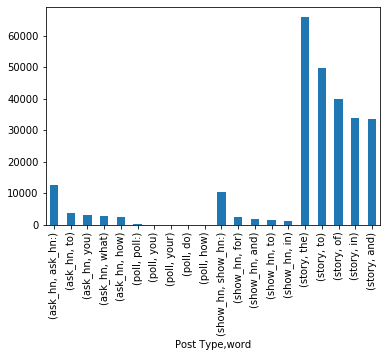

In [22]:
def frequency_plot(series, top_n=5, index_level=0):
    r = series.groupby(level=index_level).nlargest(top_n).reset_index(level=index_level, drop=True)
    r.plot.bar()
    return r.to_frame()


frequency_plot(frequency_in_cat['num_of_times'])

In [23]:
#def apperance_in_catergory_story(vocab):
#    Count_list=[]
#    for post in range(len(Unique_posts)):
#        try:
#            Count_list.append(dictionary.loc[dictionary['word']=='{}'.format(vocab)].groupby(['Post Type']).get_group('{}'.format(Unique_posts[post])).word.value_counts().to_frame().rename(columns={'word':'num_of_times'})['num_of_times'][0])
#        except KeyError:
#            Count_list.append(0)
#    
#    return Count_list

<H2> Writing eveything onto file</H2>

In [ ]:
myfile = open('model-2018-new.txt', 'w',buffering=4096)
#myfile.write("Counter  Word  Freq_in_Story  Cond_prob_sty  Fq_in_ah  Cond_pr_ah  Fq_in_show_hn  Cond_prob_sh  Freq_in_poll  Cond_prob_poll\n")
for word in range(len(Bag_of_words)):
    Count_list=[]
    for post in range(len(Unique_posts)):
        try:
            Count_list.append(dictionary.loc[dictionary['word']=='{}'.format(Bag_of_words[word])].groupby(['Post Type']).get_group('{}'.format(Unique_posts[post])).word.value_counts().to_frame().rename(columns={'word':'num_of_times'})['num_of_times'][0])
        except KeyError:
            Count_list.append(0)
        
    myfile.write("{}  {}  {} {}  {}  {}  {}  {}  {}  {}\n".format(word+1,Bag_of_words[word],Count_list[0],format((Count_list[0]+0.5)/(Total_words_each_cat['story']+Unique_words_each_cat['story']),'.8f'),Count_list[1],format((Count_list[1]+0.5)/(Total_words_each_cat['ask_hn']+Unique_words_each_cat['ask_hn']),'.8f'),Count_list[2],format((Count_list[2]+0.5)/(Total_words_each_cat['show_hn']+Unique_words_each_cat['show_hn']),'.8f'),Count_list[3],format((Count_list[3]+0.5)/(Total_words_each_cat['poll']+Unique_words_each_cat['poll']),'.8f')))

myfile.close()  

In [ ]:
myfile.close()